<p style="text-align:left;">
   <a href="../README.md">Ir al menú anterior</a>
   <span style="float:right;">
        <a href="../README.md">Ir a la unidad anterior</a>
   </span>
</p>

-----

# La partícula en un pozo armónico

<div class="alert alert-info" role="alert">
<strong>Info:</strong> Si crees que este notebook necesita algún cambio no dudes en <a href="../../../../UIBCDF-Academia/Como_contribuir/Como_contribuir.md" class="alert-link">contribuir a su desarrollo</a>.
</div>

<br>

- [Simulación del sistema](#Simulación-del-sistema)
- [Script de Python](#Script-de-Python)
- [El sistema en OpenMolecularSystems](#El-sistema-en-OpenMolecularSystems)

## Simulación del sistema

Las siguientes celdas recojen las instrucciones necesarias para simular la dinámica de Langevin de una partícula en un potencial armónico con OpenMM. La trayectoria (tiempos, posiciones, velocidades, energías cinéticas y potenciales) son guardadas como numpy arrays.

In [1]:
import numpy as np
from tqdm import tqdm
import simtk.openmm as mm
import simtk.openmm.app as app
import simtk.unit as unit

In [2]:
# Definición del sistema.

n_particles = 1
mass = (12.010*15.999)/(12.010+15.999) * unit.amu # masa reducidad de la molécula diatómica: C-O

# Creación del sistema.

system = mm.System()

for ii in range(n_particles):
    system.addParticle(mass)

In [3]:
# Añadiendo el potencial externo al sistema

K = 10.0 * unit.kilocalorie_per_mole/unit.nanometers**2

force = mm.CustomExternalForce('(K/2.0) * (x^2 + y^2 + z^2)')
force.addGlobalParameter('K', K * unit.kilocalories_per_mole/unit.angstrom**2)

for ii in range(n_particles):
    force.addParticle(ii, [])
    
_ = system.addForce(force)

In [4]:
# Definición del estado termodinámico y el integrador.

step_size = 0.01*unit.picoseconds
temperature = 300*unit.kelvin
friction = 1.0/unit.picosecond # Damping para la dinámica de Langevin

integrator = mm.LangevinIntegrator(temperature, friction, step_size)

In [5]:
# Creación de la plataforma.

platform_name = 'CUDA'
platform = mm.Platform.getPlatformByName(platform_name)

In [6]:
# Creación del contexto.

context = mm.Context(system, integrator, platform)

In [7]:
# Condiciones iniciales

initial_positions  = np.zeros([n_particles, 3], np.float32) * unit.angstroms
initial_velocities = np.zeros([n_particles, 3], np.float32) * unit.angstroms/unit.picoseconds

context.setPositions(initial_positions)
context.setVelocities(initial_velocities)

In [8]:
# Parámetros de la simulación.

simulation_time = 1.0*unit.nanosecond
saving_time = 1.0*unit.picoseconds

In [9]:
n_steps_per_period = int(saving_time/step_size) # número de pasos del periodo de guardado
n_periods = int(simulation_time/saving_time) # número de periodos guardados

In [10]:
# Creación de arrays reporteros del tiempo, la posición y la velocidad.

times = np.zeros([n_periods], np.float32) * unit.picoseconds
positions = np.zeros([n_periods, n_particles, 3], np.float32) * unit.angstroms
velocities = np.zeros([n_periods, n_particles, 3], np.float32) * unit.angstroms/unit.picosecond
potential_energies   = np.zeros([n_periods], np.float32) * unit.kilocalories_per_mole
kinetic_energies     = np.zeros([n_periods], np.float32) * unit.kilocalories_per_mole

In [11]:
# Almacenamiento en reporteros de las condiciones iniciales para tiempo 0

state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
times[0] = state.getTime()
positions[0] = state.getPositions()
velocities[0] = state.getVelocities()
kinetic_energies[0]=state.getKineticEnergy()
potential_energies[0]=state.getPotentialEnergy()

In [12]:
# Ejecuto el bucle sobre el número de periodos que vamos a simular

for ii in tqdm(range(1, n_periods)):
    context.getIntegrator().step(n_steps_per_period)
    state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
    times[ii] = state.getTime()
    positions[ii] = state.getPositions()
    velocities[ii] = state.getVelocities()
    kinetic_energies[ii]=state.getKineticEnergy()
    potential_energies[ii]=state.getPotentialEnergy()

100%|██████████| 999/999 [00:01<00:00, 552.63it/s]


Podemos guardar los arrays en un fichero. Al igual que para [la partícula libre](../particula_libre/particula_libre.ipynb) hagamos uso en esta ocasión del compresor de objetos de python ['pickle'](../../../../Glosario_librerias/Pickle.ipynb):

In [13]:
import pickle

file = open('traj.pkl','wb')
pickle.dump(times, file)
pickle.dump(positions, file)
pickle.dump(velocities, file)
pickle.dump(potential_energies, file)
pickle.dump(kinetic_energies, file)
file.close()

Podemos rescatar los datos guardados de la trayectoria de la siguiente manera:

In [14]:
file = open('traj.pkl','rb')
times = pickle.load(file)
positions = pickle.load(file)
velocities = pickle.load(file)
file.close()

Por último podemos representar gráficamente la trayectoria con la libreria Matplotlib:

In [15]:
import matplotlib.pyplot as plt

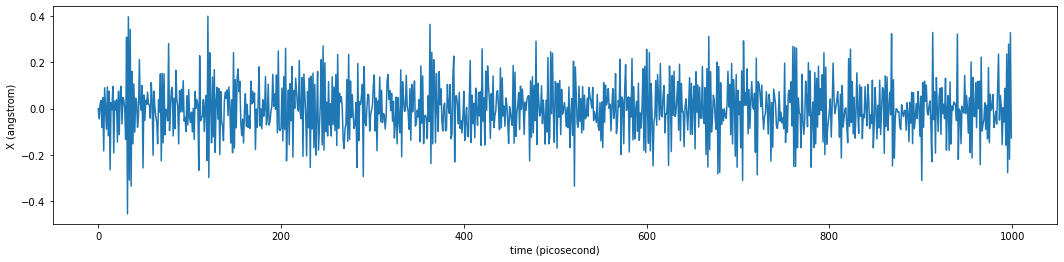

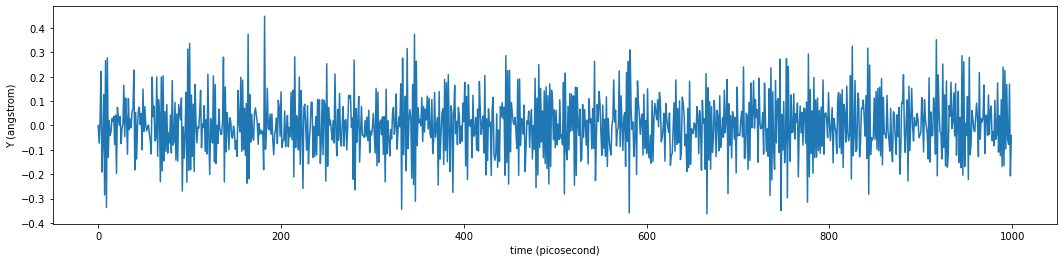

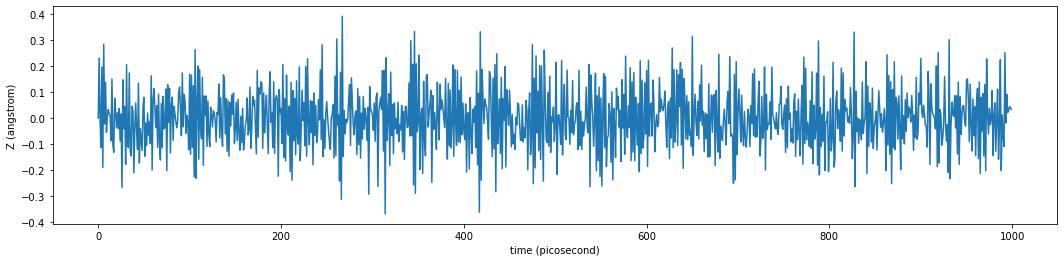

In [16]:
plt.rcParams['figure.figsize'] = 18, 4

for ii, axis_label in zip(range(3),['X','Y','Z']):
    plt.plot(times, positions[:,0,ii])
    plt.ylabel('{} ({})'.format(axis_label, positions.unit))
    plt.xlabel('time ({})'.format(times.unit))
    plt.show()


O si preferimos, la trayectoria proyectada por el espacio de dos de las dimensiones, por ejemplo $X$ y $Y$:

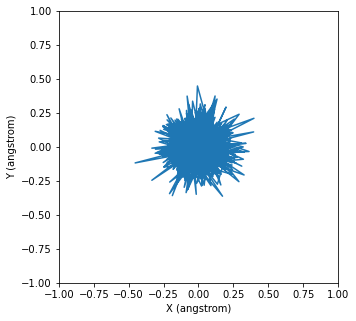

In [17]:
plt.rcParams['figure.figsize'] = 5, 5

plt.plot(positions[:,0,0], positions[:,0,1])
plt.xlabel('X ({})'.format(positions.unit))
plt.ylabel('Y ({})'.format(positions.unit))
plt.xlim([-1.0, 1.0])
plt.ylim([-1.0, 1.0])
plt.show()

Veamos ahora la energía cinética y la energía potencial:

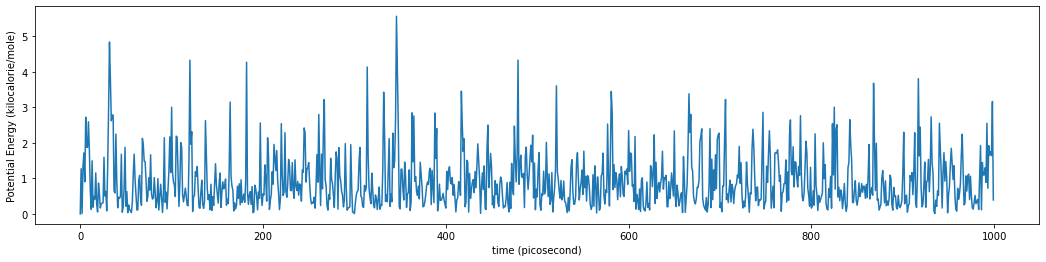

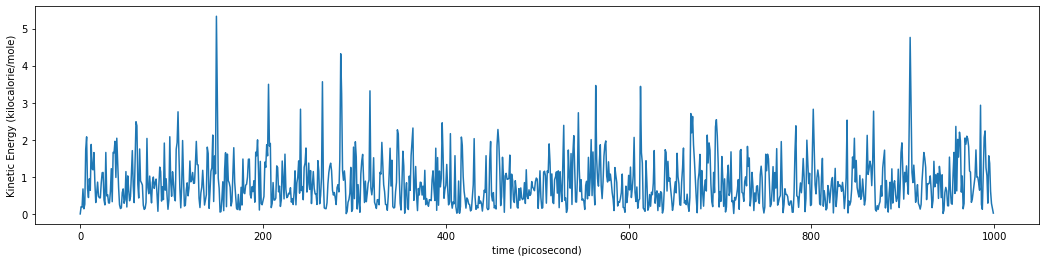

In [18]:
plt.rcParams['figure.figsize'] = 18, 4

plt.plot(times, potential_energies[:])
plt.ylabel('Potential Energy ({})'.format(potential_energies.unit))
plt.xlabel('time ({})'.format(times.unit))
plt.show()

plt.plot(times, kinetic_energies[:])
plt.ylabel('Kinetic Energy ({})'.format(kinetic_energies.unit))
plt.xlabel('time ({})'.format(times.unit))
plt.show()


Ya podemos borrar, si lo deseamos, el fichero creado:

In [19]:
import os
os.remove('traj.pkl')

## Script de Python

El flujo de ordenes anteriores para llevar a cabo la simulación de una partícula en un poco armónico en un jupyter notebook, puede ser encontrada también en forma de script en el directorio 'data/openmm_scripts' del repositorio de UIBCDF-Academia en GitHub con el nombre ['pozo_armonico.py'](https://github.com/uibcdf/Academia/tree/main/data/openmm_scripts/pozo_armonico.py). Este puede ser ejecutado en la terminal mediante el siguiente comando:

```bash
python pozo_armonico.py
```

Se genera un archivo llamado 'traj.pkl' con la compresión mediante la librería pickle de los numpy array con unidades para el tiempo, las posiciones, las velocidades, la energía potencial y la energía cinética -en este orden- guardados a intervalos de tiempo definidos en el script.

## El sistema en OpenMolecularSystems

El sistema molecular, en este caso una partícula en un potencial de tipo armónico, se encuentra disponible en la librería [OpenMolecularSystem](http://www.uibcdf.org/OpenMolecularSystems) desarrollada en la UIBCDF. El sistema puede ser simulado en distintas circunstancias de manera más cómoda haciendo uso de esta libreria.

<div style='text-align: right;'> <a href="../xxx.ipynb">Ir a la siguiente unidad</a> </div>

-------
<p xmlns:cc="http://creativecommons.org/ns#" xmlns:dct="http://purl.org/dc/terms/"><a property="dct:title" rel="cc:attributionURL" href="https://github.com/uibcdf/Academia">UIBCDF-Academia</a> por <a rel="cc:attributionURL dct:creator" property="cc:attributionName" href="https://github.com/uibcdf/Academia/graphs/contributors">UIBCDF Lab, autores y colaboradores</a> es material protegido bajo una licencia <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/deed.es?ref=chooser-v1" target="_blank" rel="license noopener noreferrer" style="display:inline-block;">Attribution-NonCommercial-ShareAlike 4.0 International<img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/cc.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/by.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/nc.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/sa.svg?ref=chooser-v1"></a></p>
